<a href="https://colab.research.google.com/github/spegas/Dacon/blob/main/LG_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

목적 : "작물 환경 데이터"와 "작물 병해 이미지"를 이용해 "작물의 종류", "병해의 종류", "병해의 진행 정도"를 진단하는 AI 모델 개발


결과물 양식 (두개의 컬럼이 존재 ['image','label'])

1. image : 이미지 파일 이름
2. label : "{작물 코드}\_{작물 상태 코드}\_{질병 피해 정도}" 형태의 문자열
"{crop}\_{disease}\_{risk}"

[평가 항목]

1. 모델 성능
  - 리더보드 Private 점수 : 30
  - 환경 데이터 사용 여부 : 10

2. 적용 가능성
  - 동작 속도 : 15
  - 모델&데이터 로딩 후 데이터 전처리 ~ 추론 ~ 결과 저장 시간 측정

3. 정보 공유
  - 코드 공유, 토론 및 답변 : 5

4. 자료
  - 제출 코드의 전처리, 학습, 추론, 설명 자료 : 각 5

5. 발표 내용, 시간 준수, 질의응답 : 20
  - 모델 창의성 / 모델의 한계 분석 등 포함

[해결해야 할 사항]
1. 이미지 용량이 너무 큼.
2. 학습시간이 오래 걸림.


[해결방법]
1. 이미지 용량이 너무 큼.
  - 이미지 일부만 학습 할 수 있는가.?
  - 
2. 학습시간이 오래 걸림
  - 다른 학습 모델이 있는가.?

In [1]:
# google driver에 있는 데이터 공유를 위한 설치 패키지
!pip install gdrive_dataset

In [2]:
# 예를 들어: https://drive.google.com/file/d/abcdefgABCDEFG1234567/view 이 있다면
# abcdefgABCDEFG1234567 이 위치가 file_id 입니다.

In [3]:
from gdrivedataset import loader

# file_id = # 이곳에 file_id 를 입력
file_id ='1DOYRWtzDlynJ0VJqDtdluzHXBzkJLZgE'
loader.load_from_google_drive(file_id)

========== files ============

data/train.zip
data/test.zip
data/train.csv
data/sample_submission.csv



In [ ]:
!unzip data/train.zip -d data

In [6]:
!unzip data/test.zip -d data

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: data/test/65823/65823.csv  
  inflating: data/test/65823/65823.jpg  
   creating: data/test/65824/
  inflating: data/test/65824/65824.jpg  
  inflating: data/test/65824/65824.csv  
   creating: data/test/65825/
  inflating: data/test/65825/65825.csv  
  inflating: data/test/65825/65825.jpg  
   creating: data/test/65827/
  inflating: data/test/65827/65827.jpg  
  inflating: data/test/65827/65827.csv  
   creating: data/test/65828/
  inflating: data/test/65828/65828.jpg  
  inflating: data/test/65828/65828.csv  
   creating: data/test/65829/
  inflating: data/test/65829/65829.jpg  
  inflating: data/test/65829/65829.csv  
   creating: data/test/65830/
  inflating: data/test/65830/65830.jpg  
  inflating: data/test/65830/65830.csv  
   creating: data/test/65831/
  inflating: data/test/65831/65831.jpg  
  inflating: data/test/65831/65831.csv  
   creating: data/test/65832/
  inflating: data/test/65832/65832.jpg  
  inflating: data/test/6583

In [7]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from glob import glob
import os
import json 
import torch
from torch import nn
from torchvision import models
from torch.utils.data import Dataset
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

In [9]:
train_data_path_list = glob('data/train/*')

 -- train_data_path -- 
data/train/21167


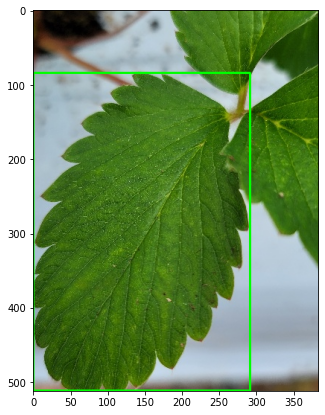

 -- train_data_path -- 
data/train/43860


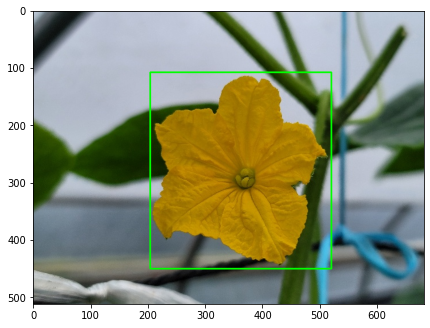

In [10]:
for train_data_path in train_data_path_list[:2]:
  print(" -- train_data_path -- ")
  print(train_data_path)

  sample_csv = pd.read_csv(glob(train_data_path+'/*.csv')[0])
  sample_image = cv2.imread(glob(train_data_path+'/*.jpg')[0])
  sample_json = json.load(open(glob(train_data_path+'/*.json')[0], 'r'))

  # visualize bbox
  plt.figure(figsize=(7,7))
  points = sample_json['annotations']['bbox'][0]
  part_points = sample_json['annotations']['part']
  img = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)

  cv2.rectangle(
      img,
      (int(points['x']), int(points['y'])),
      (int((points['x']+points['w'])), int((points['y']+points['h']))),
      (0, 255, 0),
      2
  )
  for part_point in part_points:
      point = part_point
      cv2.rectangle(
          img,
          (int(point['x']), int(point['y'])),
          (int((point['x']+point['w'])), int((point['y']+point['h']))),
          (255, 0, 0),
          1
      )
  plt.imshow(img)
  plt.show()

In [11]:
class Train_info:
    def __init__(self):
      self.train_num = None
      self.csv_file_list = None
      self.imagme_file_list = None
      self.json_file_list = None

    def set_train_num(self, num):
      self.train_num = str(num)

    def set_csv_file_list(self, file_list):
      self.csv_file_list = file_list

    def set_image_file_list(self, file_list):
      self.image_file_list = file_list

    def set_json_file_list(self, file_list):
      self.json_file_list = file_list

    def get_train_num(self):
      return self.train_num

    def get_csv_file_list(self):
      return self.csv_file_list

    def get_image_file_list(self):
      return self.image_file_list

    def get_json_file_list(self):
      return self.json_file_list

In [12]:
train_info_list = []

In [ ]:
for train_data_path in train_data_path_list:
  print(" -- train_data_path -- ")
  print(train_data_path)

  train_num = train_data_path.split('/')[-1]

  new_train_info = Train_info()
  new_train_info.set_train_num(train_num)
  new_train_info.set_csv_file_list(glob(train_data_path+'/*.csv'))
  new_train_info.set_image_file_list(glob(train_data_path+'/*.jpg'))
  new_train_info.set_json_file_list(glob(train_data_path+'/*.json'))

  train_info_list.append(new_train_info)

In [ ]:
for train_info in train_info_list:
  print(train_info)
  print(train_info.get_train_num())
  print(train_info.get_csv_file_list())
  print(train_info.get_image_file_list())
  print(train_info.get_json_file_list())

In [15]:
test_data_path_list = glob('data/test/*')

 -- test_data_path -- 
data/test/22951


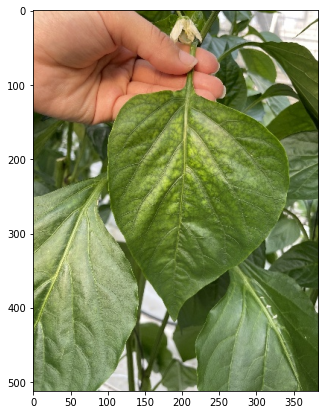

 -- test_data_path -- 
data/test/26343


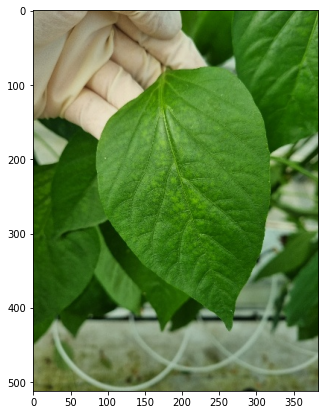

In [16]:
for test_data_path in test_data_path_list[:2]:
  print(" -- test_data_path -- ")
  print(test_data_path)

  sample_csv = pd.read_csv(glob(test_data_path+'/*.csv')[0])
  sample_image = cv2.imread(glob(test_data_path+'/*.jpg')[0])
  # sample_json = json.load(open(glob(test_data_path+'/*.json')[0], 'r'))

  # visualize bbox
  plt.figure(figsize=(7,7))
  # points = sample_json['annotations']['bbox'][0]
  # part_points = sample_json['annotations']['part']
  img = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)

  # cv2.rectangle(
  #     img,
  #     (int(points['x']), int(points['y'])),
  #     (int((points['x']+points['w'])), int((points['y']+points['h']))),
  #     (0, 255, 0),
  #     2
  # )
  # for part_point in part_points:
  #     point = part_point
  #     cv2.rectangle(
  #         img,
  #         (int(point['x']), int(point['y'])),
  #         (int((point['x']+point['w'])), int((point['y']+point['h']))),
  #         (255, 0, 0),
  #         1
  #     )
  plt.imshow(img)
  plt.show()

In [17]:
class Test_info:
    def __init__(self):
      self.test_num = None
      self.csv_file_list = None

    def set_train_num(self, num):
      self.train_num = str(num)

    def set_csv_file_list(self, file_list):
      self.csv_file_list = file_list

    def get_train_num(self):
      return self.train_num

    def get_csv_file_list(self):
      return self.csv_file_list

In [18]:
test_info_list = []

In [ ]:
for test_data_path in test_data_path_list:
  print(" -- test_data_path -- ")
  print(test_data_path)

  test_num = test_data_path.split('/')[-1]

  new_test_info = Test_info()
  new_test_info.set_train_num(train_num)
  new_test_info.set_csv_file_list(glob(train_data_path+'/*.csv'))

  test_info_list.append(new_test_info)

In [ ]:
for test_info in test_info_list:
  print(test_info)
  print(test_info.get_train_num())
  print(test_info.get_csv_file_list())